# Project 3
The prediction of molecular properties is an important task in drug discovery. The molecules' atomic composition and arrangement can already tell us a lot about their biological behavior. Each 2D molecule can be represented as a graph, where the nodes are atoms connected by edges corresponding to chemical bonds. The prediction of molecular properties can be formulized as a graph classification task, and graph neural network is usually applied for making graph-level prediction.

In this project, you need develop a model for predicting the toxicity of new molecules. This notebook provides a sample pipeline that establishes a baseline. It is expected that your methods should outperform this baseline. You are strongly encouraged to think about designing more powerful models, finetuning hyperparameters, developing better training strategies, etc.

# Install package

In [222]:
# New these two packages
!pip install torch_geometric
!pip install rdkit-pypi
%pip install torch 

Note: you may need to restart the kernel to use updated packages.


# Dataset preparation and train-valid splitting.

# Connect to Drive for files

# Import necesarry packages

In [223]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import pickle

In [224]:
# Load datasets. The training and validation sets contain both molecules and their property labels. The test set only contain molecules.
# There are 12 property tasks for prediction. Some properties labels are missing (i.e., nan). You can ignore them.
train_dataset = torch.load("train_data.pt")
valid_dataset = torch.load("valid_data.pt")
test_dataset = torch.load("test_data.pt")

print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(valid_dataset)}')
print(f'Size of test set: {len(test_dataset)}')

Size of training set: 6264
Size of validation set: 783
Size of test set: 784


# Just to see the skewedness of the tasks

# See the shapes of features

In [225]:
# one graph example
g = train_dataset[0]
print(g)

print("Get node feature matrix:")
print(g.x)
print(g.x.shape) # (num_of_nodes, num_of_node_features)

print("Get edge index matrix:")
print(g.edge_index)
print(g.edge_index.shape) # (2, num_of_edges)

print("Get edge attribute matrix:")
print(g.edge_attr)
print(g.edge_attr.shape) # (num_of_edges, num_of_edge_features)

print("Get molecular property labels:")
print(g.y)
print(g.y.shape) # (1, 12) - these are the 12 tasks

Data(x=[11, 9], edge_index=[2, 20], edge_attr=[20, 3], y=[1, 12], smiles='CC(O)(P(=O)(O)O)P(=O)(O)O')
Get node feature matrix:
tensor([[ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0]])
torch.Size([11, 9])
Get edge index matrix:
tensor([[ 0,  1,  1,  1,  1,  2,  3,  3,  3,  3,  4,  5,  6,  7,  7,  7,  7,  8,
          9, 10],
        [ 1,  0,  2,  3,  7,  1,  1,  4,  5,  6,  3,  3,  3,  1,  8,  9, 10,  7,
          7,  7]])
torch.Size([2, 20])
Get edge attribute matrix:
tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
 

As we can observe, we have 11 nodes (rows) and each node has 9 features (columns). However, the features provided by Moleculenet are discrete and of type long, so we need to convert them first to continuous embeddings in order to feed them in any ML model.

For example, the first column indicates the atomic number of a node, where 1 represents Hydrogen, 6 represents Carbon, 8 for Oxygen, according to periodic table of elements.

In [226]:
# Example of preparing data loaders.
# You can use any batch size and see what happens in model performance.

from torch_geometric.data import DataLoader

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example of creating one mini-batch
# See more info about mini-batch in pytorch geometric in https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
batch = next(iter(train_loader))
print(batch)

DataBatch(x=[588, 9], edge_index=[2, 1206], edge_attr=[1206, 3], y=[32, 12], smiles=[32], batch=[588], ptr=[33])


/Users/nguyenv/Desktop/project-3/.venv/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Visualization of molecules

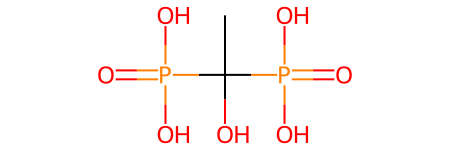

In [227]:
# visualize one 2D molecule.
from rdkit import Chem
Chem.MolFromSmiles(g.smiles)

### Calculate Weights

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[248. 190. 590. 210. 648. 297. 134. 717. 195. 282. 711. 278.]
Class weights: tensor([0.0040, 0.0053, 0.0017, 0.0048, 0.0015, 0.0034, 0.0075, 0.0014, 0.0051,
        0.0035, 0.0014, 0.0036])


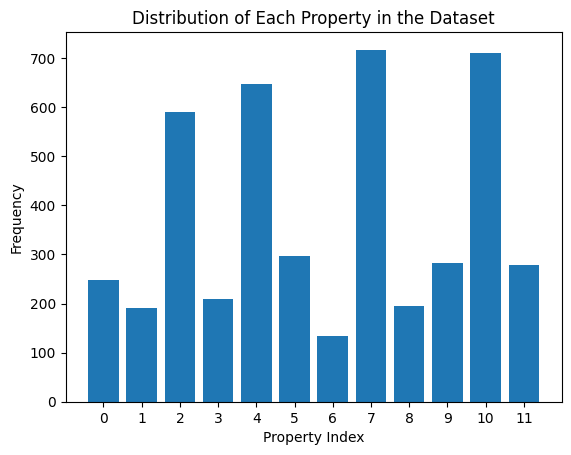

In [228]:
import numpy as np
# Assuming there are 12 properties, initialize an array to store counts for each property
property_counts = np.zeros(12)
print(property_counts)
# Iterate over the dataset to count each property
for graph in train_dataset:
    labels = graph.y
    for i in range(12):
        if not torch.isnan(labels[0, i]):
            # print(labels[0, i])
            property_counts[i] += labels[0, i]
        
print(property_counts)

# Calculate class weights
# The weight for each class is inversely proportional to its frequency
class_weights = [1.0 / count if count > 0 else max(class_weights) for count in property_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Handle the case where a class is not present in the dataset (to avoid division by zero)
class_weights[class_weights == float('inf')] = 0

print("Class weights:", class_weights)

import matplotlib.pyplot as plt
import numpy as np
# Initialize counts for each property (assuming 12 properties)
property_counts = np.zeros(12)

# Iterate over the dataset and count each property
for graph in train_dataset:
    labels = graph.y
    for i in range(12):
        if not torch.isnan(labels[0, i]):
            property_counts[i] += labels[0, i].item()

# Plotting the distribution
plt.bar(range(12), property_counts)
plt.xlabel('Property Index')
plt.ylabel('Frequency')
plt.title('Distribution of Each Property in the Dataset')
plt.xticks(range(12))
plt.show()

### Calculate Weights after adding Minority

new [599. 741. 798. 636. 903. 615. 508. 931. 621. 465. 869. 579.]
old [248. 190. 590. 210. 648. 297. 134. 717. 195. 282. 711. 278.]
Class weights: tensor([0.0040, 0.0053, 0.0017, 0.0048, 0.0015, 0.0034, 0.0075, 0.0014, 0.0051,
        0.0035, 0.0014, 0.0036])


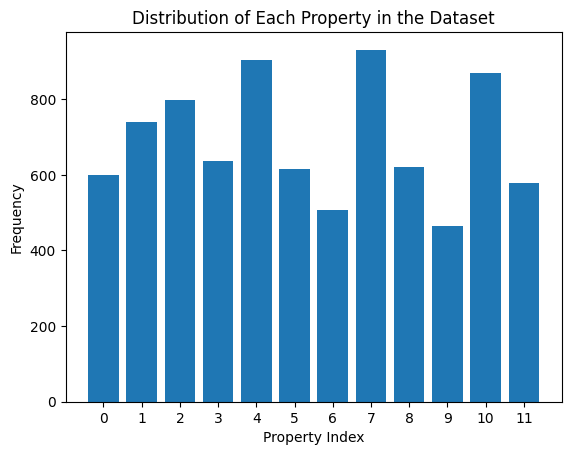

In [229]:
# Adding miniority class samples
new_train_dataset = torch.load("train_data.pt")

graph_to_add = []
new_property_counts = np.zeros(12)
count = 0

for graph in train_dataset:
    labels = graph.y
    if labels[0, 6] == 1 and labels[0, 7] != 1:
        graph_to_add.extend([graph])
    if labels[0, 6] == 1 and labels[0, 7] != 1 and labels[0, 10] != 1:
        graph_to_add.extend([graph]*2)
    if labels[0, 3] == 1 and labels[0, 7] != 1:
        graph_to_add.extend([graph]*3)
    if labels[0, 1] == 1 and labels[0, 10] != 1:
        graph_to_add.extend([graph]*3)
    if labels[0, 8] == 1 and labels[0, 10] != 1 and labels[0, 4] != 1:
        graph_to_add.extend([graph]*4)
    
new_train_dataset.extend(graph_to_add)
# calculate the new class weights
for graph in new_train_dataset:
    labels = graph.y
    for i in range(12):
        if not torch.isnan(labels[0, i]):
            new_property_counts[i] += labels[0, i]
            
print("new", new_property_counts)
print("old", property_counts)

# Calculate class weights
# The weight for each class is inversely proportional to its frequency
new_class_weights = [1.0 / count if count > 0 else 0 for count in property_counts]
new_class_weights = torch.tensor(new_class_weights, dtype=torch.float)

# Handle the case where a class is not present in the dataset (to avoid division by zero)
new_class_weights[new_class_weights == float('inf')] = 0
print("Class weights:", new_class_weights)

# Initialize counts for each property (assuming 12 properties)
property_counts = np.zeros(12)

# Iterate over the dataset and count each property
for graph in new_train_dataset:
    labels = graph.y
    for i in range(12):
        if not torch.isnan(labels[0, i]):
            property_counts[i] += labels[0, i].item()

# Plotting the distribution
plt.bar(range(12), property_counts)
plt.xlabel('Property Index')
plt.ylabel('Frequency')
plt.title('Distribution of Each Property in the Dataset')
plt.xticks(range(12))
plt.show()

In [230]:
# create a model
model = GNN(hidden_channels=64, num_node_features=9, num_classes=12)

from rdkit.Chem import AllChem

def smiles_to_fingerprints(smiles_list, radius=3, n_bits=8192):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        fingerprints.append(np.array(fp))
    return np.array(fingerprints)

# Apply to the original dataset
original_fingerprints = smiles_to_fingerprints([data.smiles for data in train_dataset])
for data, fp in zip(train_dataset, original_fingerprints):
    data.fp = torch.tensor(fp, dtype=torch.float)

# Apply to the augmented dataset
new_fingerprints = smiles_to_fingerprints([data.smiles for data in new_train_dataset])
for data, fp in zip(new_train_dataset, new_fingerprints):
    data.fp = torch.tensor(fp, dtype=torch.float)

# prediction
out = model(batch)
print(out.shape) #(num_of_graph, num_of_task)

class MyDataLoader(DataLoader):
    def collate_fn(self, batch):
        batch = super(MyDataLoader, self).collate(batch)
        batch.fp = torch.stack([data.fp for data in batch.to_data_list()])
        return batch

[21:22:20] WARNING: not removing hydrogen atom without neighbors
[21:22:33] WARNING: not removing hydrogen atom without neighbors


torch.Size([32, 12])


# Build model

In [231]:
# Atom encoder
class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(32):
            self.embeddings.append(torch.nn.Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out

from torch_geometric.nn import GATConv, GraphConv, global_mean_pool as gap, BatchNorm, TransformerConv
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes, fingerprint_dim):
        super(GNN, self).__init__()
        self.emb = AtomEncoder(hidden_channels=64)

        # Combining GCN and GAT layers
        self.gcn1 = GraphConv(hidden_channels, hidden_channels)
        self.gat1 = GATConv(hidden_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)

        self.gcn2 = GraphConv(hidden_channels, hidden_channels)
        self.gat2 = GATConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)

        self.fp_lin = Linear(fingerprint_dim, hidden_channels)

        # self.gcn3 = GCNConv(hidden_channels, hidden_channels)
        # self.gat3 = GATConv(hidden_channels, hidden_channels)
        # self.bn3 = BatchNorm(hidden_channels)

        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, batch):
        x, edge_index, batch_size, fp = batch.x, batch.edge_index, batch.batch, batch.fp
        x = self.emb(x)

        # GCN followed by GAT for each layer
        x = F.relu(self.gcn1(x, edge_index))
        x = self.bn1(self.gat1(x, edge_index))

        x = F.relu(self.gcn2(x, edge_index))
        x = self.bn2(self.gat2(x, edge_index))

        # x = F.relu(self.gcn3(x, edge_index))
        # x = self.bn3(self.gat3(x, edge_index))

        x = gap(x, batch_size)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.lin(x)
        return x

# Start training

In [232]:
# loss function and optimizer
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

criterion = nn.BCEWithLogitsLoss(reduction = "none")

In [233]:
# train and eval function
from sklearn.metrics import roc_auc_score
def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(loader): # trains by batch
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(pred.shape).to(torch.float64)

        optimizer.zero_grad()
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y
        loss = criterion(pred.to(torch.float32)[is_labeled], batch.y.to(torch.float32)[is_labeled]).mean()
        loss.backward()
        optimizer.step()

def eval(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    # For every batch in test loader
    for batch in loader:
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape))
            y_pred.append(pred)

    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()

    rocauc_list = []

    for i in range(y_true.shape[1]): # for 12 tasks...
        if np.sum(y_true[:, i] == 1) > 0 and np.sum(y_true[:, i] == 0) > 0:
            is_labeled = y_true[:, i] == y_true[:, i] # filter out NaN values
            rocauc_list.append(roc_auc_score(y_true[is_labeled, i], y_pred[is_labeled, i]))

    rocauc = sum(rocauc_list) / len(rocauc_list)

    return {'rocauc': rocauc}

In [234]:
# Training
best_score_so_far = 0.78
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

# Number of folds for cross-validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, test_ids) in enumerate(kfold.split(new_train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Subset data for this fold
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    # DataLoader instantiation
    train_loader = MyDataLoader(new_train_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = MyDataLoader(new_train_dataset, batch_size=32, sampler=test_subsampler)

    print("Start training...")
    for epoch in range(1, 200):
        print("====epoch " + str(epoch))
        train(model, device, train_loader, optimizer)

        # evaluating using the ROC - AUC score
        train_accuracy = eval(model, device, train_loader)
        val_accuracy = eval(model, device, val_loader)
        scheduler.step()

        if val_accuracy["rocauc"] > best_score_so_far:
          best_score_so_far = val_accuracy["rocauc"]
          torch.save(model.state_dict(), "model.pth")
          print(f"Best Epoch: {epoch}")

        print({'Train': train_accuracy, 'Validation': val_accuracy})

FOLD 0
--------------------------------
Start training...
====epoch 1
{'Train': {'rocauc': 0.7350503778836458}, 'Validation': {'rocauc': 0.7185331777396672}}
====epoch 2
{'Train': {'rocauc': 0.7690642962674246}, 'Validation': {'rocauc': 0.7444024244196675}}
====epoch 3
Best Epoch: 3
{'Train': {'rocauc': 0.8124829961259907}, 'Validation': {'rocauc': 0.7843858724716797}}
====epoch 4
{'Train': {'rocauc': 0.8106753296569199}, 'Validation': {'rocauc': 0.7817052442063454}}
====epoch 5
Best Epoch: 5
{'Train': {'rocauc': 0.8403721295494182}, 'Validation': {'rocauc': 0.8144406271157604}}
====epoch 6
{'Train': {'rocauc': 0.8388385656933469}, 'Validation': {'rocauc': 0.8123298746803168}}
====epoch 7
{'Train': {'rocauc': 0.8410213734563246}, 'Validation': {'rocauc': 0.8103774610786245}}
====epoch 8
{'Train': {'rocauc': 0.8271215407187097}, 'Validation': {'rocauc': 0.8004404578852791}}
====epoch 9
Best Epoch: 9
{'Train': {'rocauc': 0.8589199760251782}, 'Validation': {'rocauc': 0.833318957231825}}
=